# 本节目的实现深层神经网络基本功能

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2



In [3]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A,cache

In [4]:
#sigmoid 的求导
def sigmoid_backward(dA,cache):
    #根据链式法则
    Z = cache
    s =1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)#可以看part1-1推导过程
    assert (dZ.shape == Z.shape)
    return dZ

In [5]:
def relu(Z):
    #0和z谁大选谁
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


In [6]:
#relu的反向传播，求导
def relu_backward(dA, cache):
    '''relu本身的导数是1，根据链式法则梯度为1*dA'''
    Z = cache
    dZ = np.array(dA, copy=True) 
    #当Z小于0的时候梯度为0
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


# 作业概要
要构建你的神经网络，你需要实现几个“辅助函数”。 这些辅助函数将用于下一个任务，以构建一个双层神经网络和一个L层神经网络。 ：

- 初始化双层网络和l层神经网络
- 实现前向传播模块（如下图紫色所示）
 - 完成图层前向传播步骤的Linear部分 得到Z_1
 - 我给你激活函数方法
 - 将前面两步合成心得前向传播方法
- 计算误差  实现向后传播模块
 - 完成层反向传播线性部分
 - 我给你rule和sigmoid 的梯度函数
 - 将前面两步合并到一个新的线性函数反向传播方法
 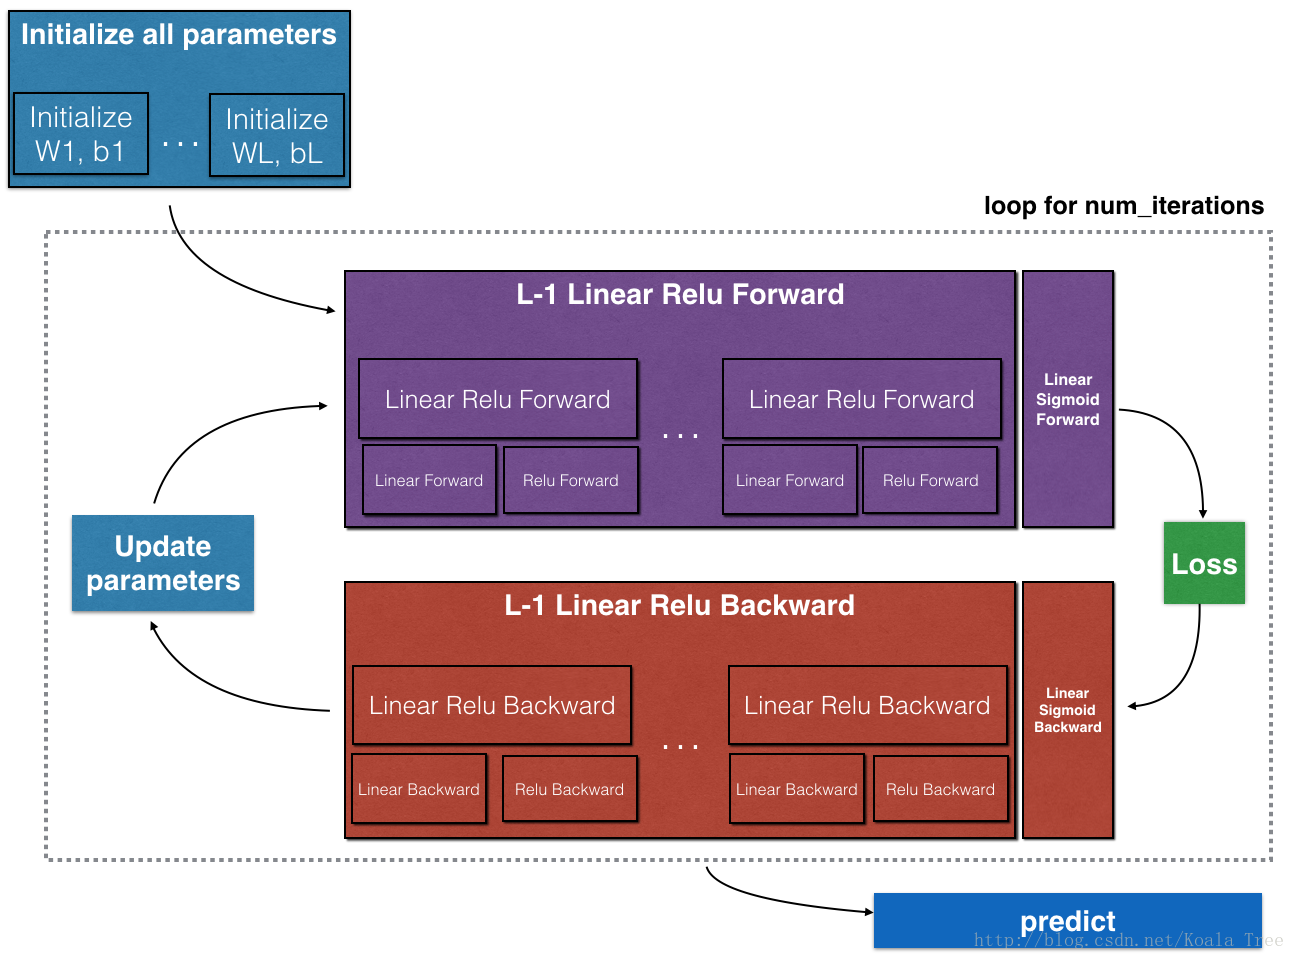

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    #随机种子
    np.random.seed(1)
    #随机初始化参数
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters    


In [8]:

def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)         

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


    return parameters


In [9]:
#线性向前
def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


In [10]:
#线性+激活正向传播
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        #得到线性值和参数
        Z, linear_cache = linear_forward(A_prev, W, b)
        #得到值和参数
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    #参数是线性参数 和激励函数
    cache = (linear_cache, activation_cache)

    return A, cache


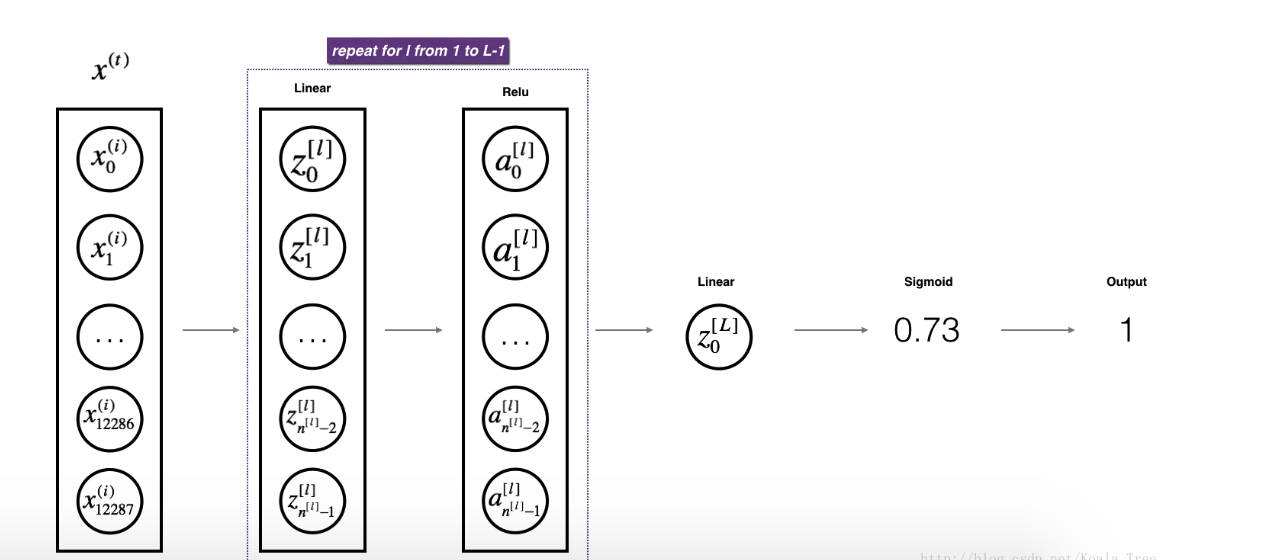

In [11]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X
    #因为有两个参数 w和b 所以要除以2 才是一共有多少组参数，//代表取整
    L = len(parameters) // 2                 
    #网络一共会有L层线性+rule
    for l in range(1, L):
        A_prev = A 
        #返回值和线性参数和激励函数,这个返回值又去参与到循环
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
        

    #最终得到的数列参与到sigmoid中
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches


In [12]:
#计算误差
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m
    cost = np.squeeze(cost)     
    assert(cost.shape == ())

    return cost


In [13]:
#线性向后（反向传播）
def linear_backward(dZ, cache):
    #得到线性参数
    A_prev, W, b = cache
    m = A_prev.shape[1]
    #w本身的导数是A_prev 链式法则需要乘下一层导数
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    #因为有很多层线性+rule 所以需要根据这个值导数去求前面层的导数
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


In [14]:
#激活函数求导
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache

    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db


In [15]:
#融合一下反向传播
def L_model_backward(AL, Y, caches):
    #传入参数分别为：最终输出值，真实值，线性参数w，b
    grads = {}
    #线性参数的数量
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 

    #把-(ylog(a)+(1-y)log(1-a))求导得到
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    

    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        

    return grads


In [16]:
#更新参数
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters


array([1.42857143, 0.        , 3.33333333])